In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


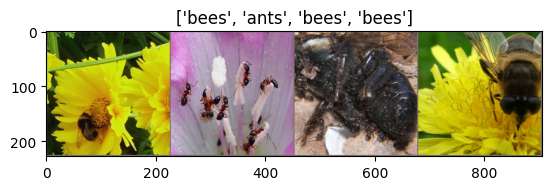

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
#파라미터 freeze
for param in model_ft.parameters():
    param.requires_grad = False
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6016 Acc: 0.6680
val Loss: 0.4743 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4649 Acc: 0.8238
val Loss: 0.3938 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4293 Acc: 0.8279
val Loss: 0.3508 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4317 Acc: 0.8074
val Loss: 0.3627 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.3834 Acc: 0.8484
val Loss: 0.3639 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3935 Acc: 0.8320
val Loss: 0.3166 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4511 Acc: 0.7664
val Loss: 0.3031 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3913 Acc: 0.7910
val Loss: 0.2848 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3419 Acc: 0.8566
val Loss: 0.2906 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3725 Acc: 0.8361
val Loss: 0.2995 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.4153 Acc: 0.8115
val Loss: 0.3365 Acc: 0.8562

Epoch 11/24
----------
train Loss: 0.3941 Acc: 0.8197
val Loss: 0.3090 Acc: 0.8824

Ep

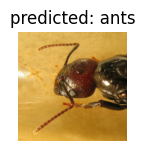

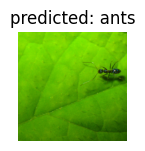

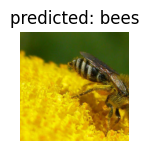

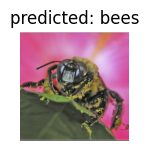

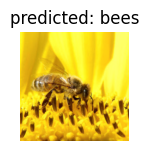

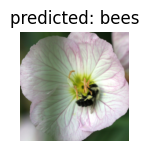

In [10]:
visualize_model(model_ft)

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader, device):
    """
    학습된 모델의 성능을 평가합니다.
    (Accuracy, Recall, F1-score, AUROC 등)
    """

    # 모델을 평가 모드로 설정
    model.eval()

    all_labels = []     # 실제 레이블을 저장할 리스트
    all_preds = []      # 모델의 예측 레이블(0 또는 1)을 저장할 리스트
    all_scores = []     # AUROC 계산을 위한 모델의 확률 점수(positive class)를 저장할 리스트

    # 그래디언트 계산 비활성화
    with torch.no_grad():
        for inputs, labels in dataloader:
            # 데이터를 지정된 장치(GPU 또는 CPU)로 이동
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델 순전파 (Forward pass)
            outputs = model(inputs)

            # 1. Accuracy, Recall, F1-score 계산을 위한 예측 레이블
            #    logits(outputs)에서 가장 큰 값의 인덱스를 예측 레이블로 사용
            _, preds = torch.max(outputs, 1)

            # 2. AUROC 계산을 위한 확률 점수
            #    logits를 softmax를 통과시켜 확률로 변환
            probabilities = F.softmax(outputs, dim=1)
            # 'positive' 클래스(여기서는 클래스 1)의 확률을 'score'로 사용
            scores = probabilities[:, 1]

            # CPU로 데이터 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    # 리스트를 NumPy 배열로 변환 (sklearn 함수가 NumPy 배열을 입력으로 받음)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_scores = np.array(all_scores)

    # --- 성능 지표 계산 및 출력 ---

    print("==========================================")
    print("           Classification Report")
    print("==========================================")
    # 1. Classification Report (Precision, Recall, F1-score, Accuracy)
    # target_names는 클래스 이름 (예: ['Class 0', 'Class 1'] 또는 ['Negative', 'Positive'])
    # 이 예제에서는 0과 1로 가정합니다.
    # Use the actual class names from the dataset
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

    print("==========================================")
    print("                 AUROC")
    print("==========================================")
    # 2. AUROC (Area Under the ROC Curve)
    #    AUROC는 실제 레이블과 'positive' 클래스에 대한 확률 점수로 계산합니다.
    auroc = None # Initialize auroc
    try:
        auroc = roc_auc_score(all_labels, all_scores)
        print(f"AUROC (Area Under ROC Curve): {auroc:.4f}")
    except ValueError as e:
        print(f"AUROC 계산 중 오류 발생: {e}")
        print(" (데이터셋에 하나의 클래스만 존재할 경우 발생할 수 있습니다.)")


    print("==========================================")
    print("             Confusion Matrix")
    print("==========================================")
    # 3. (보너스) Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    print("==========================================")

    # 계산된 주요 지표를 딕셔너리로 반환할 수도 있습니다.
    report_dict = classification_report(all_labels, all_preds, output_dict=True, target_names=class_names)

    # Use the actual class names from the dataset when accessing the dictionary
    positive_class_name = class_names[1] # Assuming the second class is the positive one

    return {
        'accuracy': report_dict['accuracy'],
        'recall ({})'.format(positive_class_name): report_dict[positive_class_name]['recall'],
        'f1-score ({})'.format(positive_class_name): report_dict[positive_class_name]['f1-score'],
        'auroc': auroc,
        'classification_report': report,
        'confusion_matrix': cm
    }

In [14]:
evaluate_model(model_ft, dataloaders['val'], device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


           Classification Report
              precision    recall  f1-score   support

        ants       0.92      0.93      0.92        70
        bees       0.94      0.93      0.93        83

    accuracy                           0.93       153
   macro avg       0.93      0.93      0.93       153
weighted avg       0.93      0.93      0.93       153

                 AUROC
AUROC (Area Under ROC Curve): 0.9711
             Confusion Matrix
[[65  5]
 [ 6 77]]


{'accuracy': 0.9281045751633987,
 'recall (bees)': 0.927710843373494,
 'f1-score (bees)': 0.9333333333333333,
 'auroc': np.float64(0.9710843373493976),
 'classification_report': '              precision    recall  f1-score   support\n\n        ants       0.92      0.93      0.92        70\n        bees       0.94      0.93      0.93        83\n\n    accuracy                           0.93       153\n   macro avg       0.93      0.93      0.93       153\nweighted avg       0.93      0.93      0.93       153\n',
 'confusion_matrix': array([[65,  5],
        [ 6, 77]])}